## Sarsa($\lambda$): On Policy TD Control

Here is the implementation of **Sarsa($\lambda$)**, an on-policy temporal difference control algorithm. The backward view of the algorithm is implemented using eligibility traces.

Algorithm is run on following environments from openai.gym:
- Blackjack-v0
- CliffWalking-v0

In [0]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import sys
import gym
from gym import logger as gymlogger
from mpl_toolkits.axes_grid1 import make_axes_locatable

matplotlib.style.use('ggplot')
gymlogger.set_level(40) #error only
%matplotlib inline

## CliffWalking environment

- A state in the current position in 12x4 grid
- Action is one of 4 possible directions left,right,up,down

In [0]:
env_cw = gym.make("CliffWalking-v0")
print(env_cw.observation_space)
print(env_cw.action_space)

Discrete(48)
Discrete(4)


## Blackjack environment

A state in Blackjask is defined by three things:<br/>
1. Player current sum (1-31)
2. Dealer's one showing card (1-10)
3. Does player holds a usable ace (0 or 1)

In [0]:
env_bj = gym.make("Blackjack-v0")
print(env_bj.observation_space)
print(env_bj.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


## Sarsa($\lambda$) Algorithm

In [0]:
def get_epsilon_greedy_policy(env, q_values, epsilon=0.1):
    """
    Make an epsilon-greedy policy from given Q-values

    Returns:
        policy: epsilon-greedy policy which takes random action with
                probability epsilon/num_actions, otherwise takes
                greedy action
    """
    num_actions = env.action_space.n

    def policy(state):
        if state not in q_values:
            return np.ones((num_actions), dtype=float) / num_actions
        greedy_action = q_values[state].argmax()
        action_probs = np.ones((num_actions)) * (epsilon/num_actions)
        action_probs[greedy_action] += 1-epsilon
        return action_probs
    
    return policy

In [0]:
def sarsa_lambda(env, num_episodes=10000, gamma=1.0, alpha=0.015,lamda=0.5,
                 epsilon=1.0, glie=True, decay_factor=0.99999, min_epsilon=0.05):
    """
    Performs on-policy control using Sarsa(lambda) algorithm

    Args:
        env: Learning enviroment, e.g. Blackjack
        num_episodes: Number of episodes to sample
        gamma: Discount factor
        alpha: Step size / learning rate
        epsilon: epsilon to used for making epsilon-greedy policy.
        glie: If set to True, epsilon decay is used to make policy GLIE
              and have GLIE convergence properties.
        decay_factor: used if glie is set to True
        min_epsilon: min value that epsilon can be decayed to
    Returns:
        q_values: dictionary mapping states (tuple) to array of action values
                  i.e. s -> np.array([q(s,a1),q(s,a2),...])
        policy: the final (epsilon-)greedy policy
        stats: algorithm learning statistics
    """

    num_actions = env.action_space.n
    q_values = defaultdict(lambda: np.zeros(num_actions))
    policy = get_epsilon_greedy_policy(env, q_values, epsilon)
    stats = {'episode_lengths': [0 for _ in range(num_episodes)],
             'episode_returns': [0 for _ in range(num_episodes)]}

    for episode_num in range(num_episodes):
        if (episode_num+1) % 1000 == 0:
            print("\rFinished {}/{} episodes".format(episode_num+1,num_episodes), end="")
            sys.stdout.flush()
        
        state = env.reset()
        e_traces = defaultdict(float) # Eligibility Trace

        # Choose action based on above policy
        action_probs = policy(state)
        action = np.random.choice(np.arange(num_actions), p=action_probs)

        while True: # Until eipsode finishes
            # Take action
            next_state, reward, done, info = env.step(action)
            
            # Choose next action
            next_action_probs = policy(next_state) 
            next_action = np.random.choice(np.arange(num_actions), p=next_action_probs)
            next_q_value = q_values[next_state][next_action]
            # Q-value for terminal state is 0
            if done: next_q_value = 0
            
            delta = reward + gamma*next_q_value - q_values[state][action]
            e_traces[(state,action)] += 1
            for (s,a) in e_traces:
                q_values[s][a] += alpha * delta * e_traces[(s,a)]
                e_traces[(s,a)] = gamma * lamda * e_traces[(s,a)]

            policy = get_epsilon_greedy_policy(env, q_values, epsilon)
            state = next_state
            action = next_action

            # Update stats
            stats['episode_returns'][episode_num] += reward
            stats['episode_lengths'][episode_num] += 1
            if done: break

        if glie: epsilon = max(min_epsilon, epsilon*decay_factor)
    return q_values, policy, stats

## Helper Functions to Plot State Values and Policy for Blackjack

In [0]:
# Following function to plot the Blackjack value function is based on the
# implementation here: https://github.com/dennybritz/reinforcement-learning/

def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x, max_x = 11, 22
    min_y, max_y = min(k[1] for k in V.keys()), max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, ax, title):
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)

    fig = plt.figure(figsize=(20, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    plot_surface(X, Y, Z_noace, ax1, "{} (No Usable Ace)".format(title))
    ax2 = fig.add_subplot(122, projection='3d')
    plot_surface(X, Y, Z_ace, ax2, "{} (Usable Ace)".format(title))

In [0]:
def plot_policy(policy, title):
    x_range = np.arange(11, 22)
    y_range = np.arange(10, 0, -1)
    X, Y = np.meshgrid(x_range, y_range)

    # Optimal actions - Break ties in favor of Hit (since states with lower
    # deck values are less frequently sampled, and are always hit)
    Z_noace = np.array([[0 if policy((x,y,0))[0] > policy((x,y,0))[1] else 1 for x in x_range] for y in y_range])
    Z_ace = np.array([[0 if policy((x,y,1))[0] > policy((x,y,1))[1] else 1 for x in x_range] for y in y_range])

    def plot_grid(X, Y, Z, ax, title):
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_title(title)
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])

    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(121)
    plot_grid(X, Y, Z_noace, ax1, "{} (No Usable Ace)".format(title))
    ax2 = fig.add_subplot(122)
    plot_grid(X, Y, Z_ace, ax2, "{} (Usable Ace)".format(title))

In [0]:
def plot_stats(stats):
    episode_returns = (pd.Series(stats['episode_returns']) > 0).rolling(100000).mean()
    plt.plot(episode_returns, 'o')
    plt.title("Win rate over time (Smoothing Window = 100000)")
    plt.xlabel("Episode")
    plt.ylabel("Fraction of games won")
    plt.show()

## Results on Blackjack Environment

In [0]:
q_values_bj, policy_bj, stats_bj = sarsa_lambda(env_bj, num_episodes=300000, gamma=1.0, alpha=0.025,
                         lamda=0.6, epsilon=1.0, glie=True, decay_factor=0.9999, min_epsilon=0.05)

Finished 300000/300000 episodes

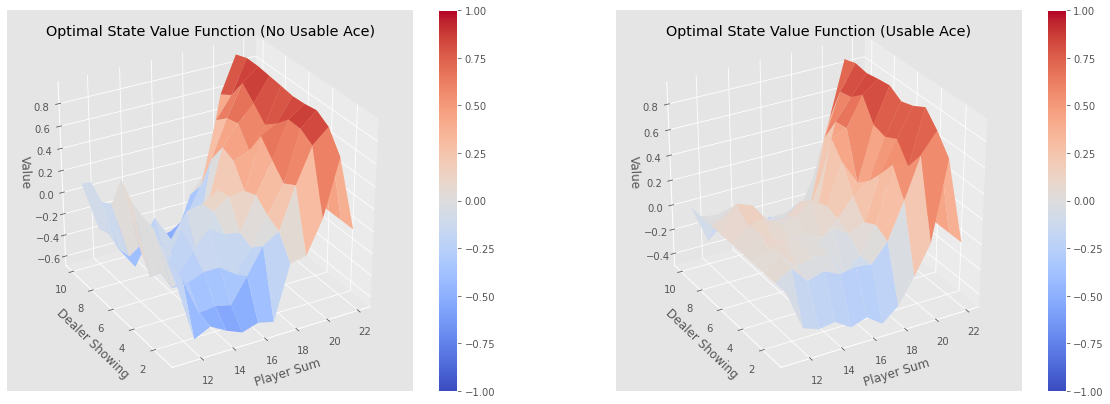

In [0]:
v_values_bj = defaultdict(float)
for state,actions in q_values_bj.items():
    max_action_value = np.max(actions)
    v_values_bj[state] = max_action_value

plot_value_function(v_values_bj, "Optimal State Value Function")

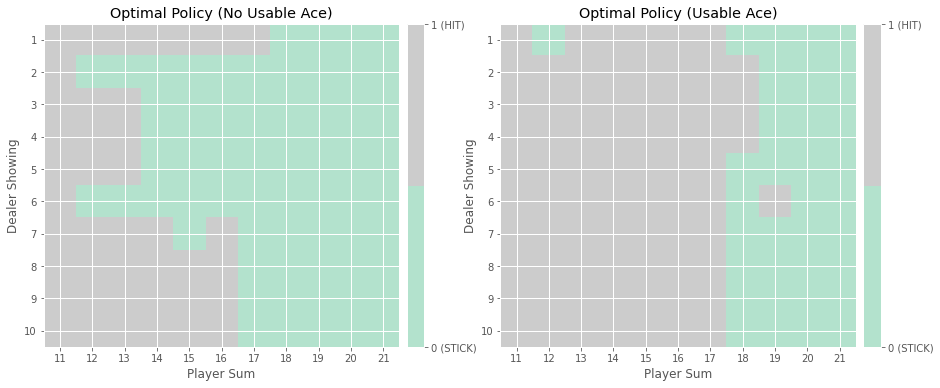

In [0]:
plot_policy(policy_bj, "Optimal Policy")

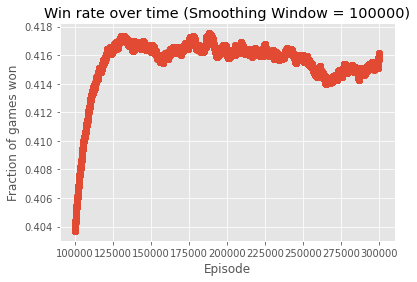

In [0]:
plot_stats(stats_bj)

## Results on Cliff-Walking Environment

In [0]:
q_values_cw, policy_cw, stats_cw = sarsa_lambda(env_cw, num_episodes=2000, gamma=1.0, alpha=0.017,
                         lamda=0.3, epsilon=1.0, glie=True, decay_factor=0.99, min_epsilon=0.03)

Finished 2000/2000 episodes

In [0]:
def plot_stats_cw(stats):
    episode_returns = pd.Series(stats['episode_returns']).rolling(100).mean()
    episode_lengths = pd.Series(stats['episode_lengths']).rolling(100).mean()
    fig = plt.figure(figsize=(15,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(episode_returns)
    ax1.set_ylim((-80,0))
    ax1.set_title("Episode returns over time (smoothing window = 100)")
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Total reward in Episode ")

    ax2.plot(episode_lengths)
    ax2.set_ylim((0,80))
    ax2.set_title("Episode lenghts over time (smoothing window = 100)")
    ax2.set_xlabel("Episode")
    ax2.set_ylabel("Episode length")
    plt.show()

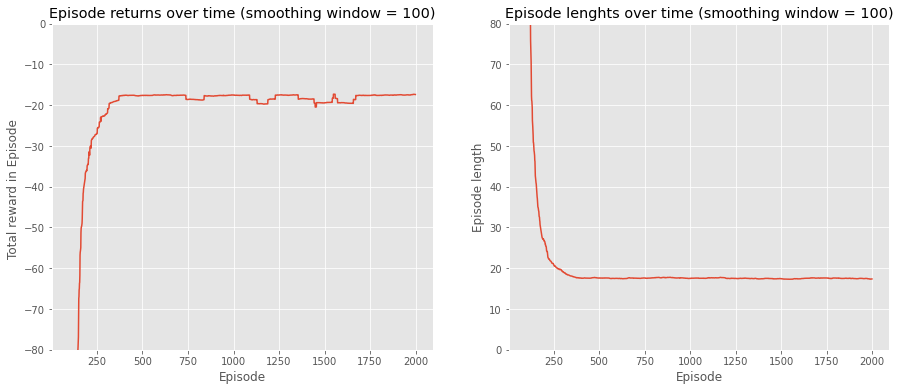

In [0]:
plot_stats_cw(stats_cw)

### NOTE
In cliff-walking environment, just like Sarsa, Sarsa($\lambda$) also finds the policy which has
- average episode length 17-18
- average reward per episode between -17 to -18 (which is obvious)

So, Sarsa($\lambda$) is finding the safest route through the cliff.